In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
import tensorflow as tf

In [2]:
c = 'C:/Users/Raj/COVID/COVID-19_Radiography_Dataset/COVID/images'
n = 'C:/Users/Raj/COVID/COVID-19_Radiography_Dataset/Normal/images'
p = 'C:/Users/Raj/COVID/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [3]:
random.seed(42)
filenames = os.listdir(c) + random.sample(os.listdir(n), 2500) + os.listdir(p)

In [4]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

In [5]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})        

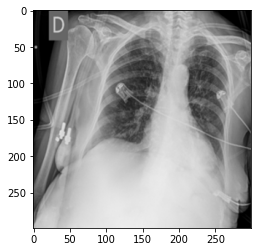

In [6]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

In [7]:
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [8]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [9]:
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [10]:
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 5968 validated image filenames belonging to 3 classes.


In [11]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

Found 747 validated image filenames belonging to 3 classes.


In [12]:
loaded_model = tf.keras.applications.inception_v3.InceptionV3(
        # Freezing the weights of the top layer in the InceptionResNetV2 pre-traiined model
        include_top = False,

        # Use Imagenet weights
        weights = 'imagenet',

        # Define input shape to 224x224x3
        input_shape = (224 , 224 , 3),
)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'avg_pool')(loaded_model.output)
x =tf.keras.layers.Dropout(0.75)(x)
x = tf.keras.layers.BatchNormalization(
                      axis=-1,
                      momentum=0.99,
                      epsilon=0.01,
                      center=True,
                      scale=True,
                      beta_initializer="zeros",
                      gamma_initializer="ones",
                      moving_mean_initializer="zeros",
                      moving_variance_initializer="ones",
                  )(x)
out = tf.keras.layers.Dense(3, activation = 'softmax', name = 'dense_output')(x)


    # Build the Keras model
model = tf.keras.models.Model(inputs = loaded_model.input, outputs = out)
    # Compile the model

model.compile(
        # Set optimizer to Adam(0.0001)
        optimizer = tf.keras.optimizers.Adam(learning_rate= 3e-4),
        #optimizer= SGD(lr=0.001, decay=1e-6, momentum=0.99, nesterov=True),
        # Set loss to binary crossentropy
        #loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        loss = 'categorical_crossentropy',
        # Set metrics to accuracy
        metrics = ['accuracy']
    )


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [14]:
history = model.fit(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=13,
                       
                        )

Epoch 1/13
187/187 [==============================] - 1259s 7s/step - loss: 0.6479 - accuracy: 0.7690 - val_loss: 0.7653 - val_accuracy: 0.8286
Epoch 2/13
187/187 [==============================] - 1247s 7s/step - loss: 0.2457 - accuracy: 0.9146 - val_loss: 0.3332 - val_accuracy: 0.8849
Epoch 3/13
187/187 [==============================] - 1282s 7s/step - loss: 0.1781 - accuracy: 0.9419 - val_loss: 0.2573 - val_accuracy: 0.9050
Epoch 4/13
187/187 [==============================] - 1262s 7s/step - loss: 0.1517 - accuracy: 0.9486 - val_loss: 0.2140 - val_accuracy: 0.9250
Epoch 5/13
187/187 [==============================] - 1246s 7s/step - loss: 0.1512 - accuracy: 0.9387 - val_loss: 0.1700 - val_accuracy: 0.9598
Epoch 6/13
187/187 [==============================] - 1222s 7s/step - loss: 0.1097 - accuracy: 0.9576 - val_loss: 0.2525 - val_accuracy: 0.9116
Epoch 7/13
187/187 [==============================] - 1269s 7s/step - loss: 0.1243 - accuracy: 0.9550 - val_loss: 0.0755 - val_accuracy:

In [15]:
test_set = valid_data_gen.flow_from_dataframe(
    test_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 746 validated image filenames belonging to 3 classes.


In [16]:
model.evaluate(test_set)

24/24 [==============================] - 23s 939ms/step - loss: 0.1122 - accuracy: 0.9584


[0.1122233122587204, 0.9584450125694275]

In [17]:
model.save('Covid-19.h5')